### 임폴트 및 주석

In [1]:
#---------------------
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#---------------------------------
from sklearn.metrics import f1_score, precision_score, recall_score

#---------------------------------
# ARIMA MODEL
from statsmodels.tsa.arima.model import ARIMA
#---------------------------------
# datetime
from datetime import datetime
#--------------------------------

## 각 컬럼명은 따로 폰트 설치가 필요하기에
## 영문으로 다 변경하였습니다.

## 이하 변경된 컬럼명의 풀네임입니다.
# datetime : 일시
# 'tht', #the highest temperature 최고기온
# 'tlt', #the lowest temperature 최저기온
# 'dtr', #daily temperature range 일교차 
# 'ah', #Average humidity 평균습도
# 'aws', #average wind speed 평균풍속
# 'at', #average temperature 평균기온

## 파일 불러오기

In [2]:

train_path = 'train.csv' 
submission_path = 'sample_submission.csv' 

print('*'*80)

df_train = pd.read_csv(train_path)
df_submission = pd.read_csv(submission_path)

print('*'*80)

print(df_train)

print('*'*80)

print(df_submission)

print('*'*80)

# isnull().sum()
# outlier(이상치제거)

# 관계 분석
# 모델링 (머신러닝)
# XGBosst Lightgbm 
# 분류의 Classifier . DecisionTreeClassfier

********************************************************************************
********************************************************************************
               일시  최고기온  최저기온   일교차  강수량  평균습도  평균풍속  일조합    일사합   일조율  평균기온
0      1960-01-01   2.2  -5.2   7.4  NaN  68.3   1.7  6.7    NaN   NaN  -1.6
1      1960-01-02   1.2  -5.6   6.8  0.4  87.7   1.3  0.0    NaN   NaN  -1.9
2      1960-01-03   8.7  -2.1  10.8  0.0  81.3   3.0  0.0    NaN   NaN   4.0
3      1960-01-04  10.8   1.2   9.6  0.0  79.7   4.4  2.6    NaN   NaN   7.5
4      1960-01-05   1.3  -8.2   9.5  NaN  44.0   5.1  8.2    NaN   NaN  -4.6
...           ...   ...   ...   ...  ...   ...   ...  ...    ...   ...   ...
23006  2022-12-27   3.3  -7.3  10.6  NaN  69.8   1.8  8.8  10.25  91.7  -2.6
23007  2022-12-28   0.1  -6.0   6.1  0.1  58.1   2.5  8.7  10.86  90.6  -3.3
23008  2022-12-29   2.1  -7.8   9.9  0.0  56.3   1.7  9.0  10.88  93.8  -2.9
23009  2022-12-30   2.3  -4.4   6.7  0.0  65.6   1.9  7.9  10.84  82

## 파일 속성 확인

In [3]:
df_train.info() # 자료형 변환해야 하는 컬럼 구분법..?
                # 일시컬럼이 의미를 가지는지..? 어떤의미...?


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23011 entries, 0 to 23010
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      23011 non-null  object 
 1   최고기온    23008 non-null  float64
 2   최저기온    23008 non-null  float64
 3   일교차     23007 non-null  float64
 4   강수량     9150 non-null   float64
 5   평균습도    23011 non-null  float64
 6   평균풍속    23007 non-null  float64
 7   일조합     22893 non-null  float64
 8   일사합     18149 non-null  float64
 9   일조율     22645 non-null  float64
 10  평균기온    23011 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.9+ MB


In [4]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   일시      358 non-null    object
 1   평균기온    358 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.7+ KB


### 누락 데이터 제거 및 필요 없는 컬럼 제거

In [5]:
n_nulls1 = df_train.isnull().sum()
print(f'학습용 데이터의 누락데이터 값 : \n{n_nulls1}')

print('*'*80)

n_nulls2 = df_submission.isnull().sum()
print(f'제출 양식의 누락 데이터 값 : \n{n_nulls2}')

print('*'*80)

columns1=df_train.columns

print(f'학습용 데이터의 컬럼 : \n{columns1}')

columns2=df_submission.columns

print(f'제출 양식 파일의 컬럼 : \n{columns2}')

# 평균 기온 : 정답 컬럼.

# 강수량, 일사환, 일조합, 일조율 4개 컬럼 너무 많으니 드랍할 것.



학습용 데이터의 누락데이터 값 : 
일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64
********************************************************************************
제출 양식의 누락 데이터 값 : 
일시      0
평균기온    0
dtype: int64
********************************************************************************
학습용 데이터의 컬럼 : 
Index(['일시', '최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율',
       '평균기온'],
      dtype='object')
제출 양식 파일의 컬럼 : 
Index(['일시', '평균기온'], dtype='object')


In [6]:
# 강수량, 일사합, 일조합, 일조율 Drop

cleaned_df = df_train.drop(columns=['강수량','일사합','일조합','일조율'])

print(cleaned_df)

               일시  최고기온  최저기온   일교차  평균습도  평균풍속  평균기온
0      1960-01-01   2.2  -5.2   7.4  68.3   1.7  -1.6
1      1960-01-02   1.2  -5.6   6.8  87.7   1.3  -1.9
2      1960-01-03   8.7  -2.1  10.8  81.3   3.0   4.0
3      1960-01-04  10.8   1.2   9.6  79.7   4.4   7.5
4      1960-01-05   1.3  -8.2   9.5  44.0   5.1  -4.6
...           ...   ...   ...   ...   ...   ...   ...
23006  2022-12-27   3.3  -7.3  10.6  69.8   1.8  -2.6
23007  2022-12-28   0.1  -6.0   6.1  58.1   2.5  -3.3
23008  2022-12-29   2.1  -7.8   9.9  56.3   1.7  -2.9
23009  2022-12-30   2.3  -4.4   6.7  65.6   1.9  -1.8
23010  2022-12-31   2.1  -5.1   7.2  65.5   1.4  -1.2

[23011 rows x 7 columns]


### 한글컬럼을 영문컬럼으로 변환

In [7]:
cleaned_df.columns = ['datetime',
                      'tht', #the highest temperature 최고기온
                      'tlt', #the lowest temperature 최저기온
                      'dtr', #daily temperature range 일교차
                      'ah', #Average humidity 평균습도
                      'aws', #average wind speed 평균풍속
                      'at', #average temperature 평균기온
]

print('*'*80)

print(cleaned_df)

********************************************************************************
         datetime   tht  tlt   dtr    ah  aws   at
0      1960-01-01   2.2 -5.2   7.4  68.3  1.7 -1.6
1      1960-01-02   1.2 -5.6   6.8  87.7  1.3 -1.9
2      1960-01-03   8.7 -2.1  10.8  81.3  3.0  4.0
3      1960-01-04  10.8  1.2   9.6  79.7  4.4  7.5
4      1960-01-05   1.3 -8.2   9.5  44.0  5.1 -4.6
...           ...   ...  ...   ...   ...  ...  ...
23006  2022-12-27   3.3 -7.3  10.6  69.8  1.8 -2.6
23007  2022-12-28   0.1 -6.0   6.1  58.1  2.5 -3.3
23008  2022-12-29   2.1 -7.8   9.9  56.3  1.7 -2.9
23009  2022-12-30   2.3 -4.4   6.7  65.6  1.9 -1.8
23010  2022-12-31   2.1 -5.1   7.2  65.5  1.4 -1.2

[23011 rows x 7 columns]


### NaN값 처리

In [8]:
cleaned_df.isnull().sum()

# Deleting NaN using dropna(subset)

cleaned_df.dropna(subset=['tht','tlt','dtr','aws'], inplace=True)

print(cleaned_df)

cleaned_df.isnull().sum()

         datetime   tht  tlt   dtr    ah  aws   at
0      1960-01-01   2.2 -5.2   7.4  68.3  1.7 -1.6
1      1960-01-02   1.2 -5.6   6.8  87.7  1.3 -1.9
2      1960-01-03   8.7 -2.1  10.8  81.3  3.0  4.0
3      1960-01-04  10.8  1.2   9.6  79.7  4.4  7.5
4      1960-01-05   1.3 -8.2   9.5  44.0  5.1 -4.6
...           ...   ...  ...   ...   ...  ...  ...
23006  2022-12-27   3.3 -7.3  10.6  69.8  1.8 -2.6
23007  2022-12-28   0.1 -6.0   6.1  58.1  2.5 -3.3
23008  2022-12-29   2.1 -7.8   9.9  56.3  1.7 -2.9
23009  2022-12-30   2.3 -4.4   6.7  65.6  1.9 -1.8
23010  2022-12-31   2.1 -5.1   7.2  65.5  1.4 -1.2

[23003 rows x 7 columns]


datetime    0
tht         0
tlt         0
dtr         0
ah          0
aws         0
at          0
dtype: int64

### 행 인덱스 재설정

In [9]:
cleaned_df.reset_index(drop=True, inplace=True)

print(cleaned_df)

         datetime   tht  tlt   dtr    ah  aws   at
0      1960-01-01   2.2 -5.2   7.4  68.3  1.7 -1.6
1      1960-01-02   1.2 -5.6   6.8  87.7  1.3 -1.9
2      1960-01-03   8.7 -2.1  10.8  81.3  3.0  4.0
3      1960-01-04  10.8  1.2   9.6  79.7  4.4  7.5
4      1960-01-05   1.3 -8.2   9.5  44.0  5.1 -4.6
...           ...   ...  ...   ...   ...  ...  ...
22998  2022-12-27   3.3 -7.3  10.6  69.8  1.8 -2.6
22999  2022-12-28   0.1 -6.0   6.1  58.1  2.5 -3.3
23000  2022-12-29   2.1 -7.8   9.9  56.3  1.7 -2.9
23001  2022-12-30   2.3 -4.4   6.7  65.6  1.9 -1.8
23002  2022-12-31   2.1 -5.1   7.2  65.5  1.4 -1.2

[23003 rows x 7 columns]


In [10]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'nanummyeongjo'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 24.
plt.rcParams['xtick.labelsize'] = 12.
plt.rcParams['ytick.labelsize'] = 12.
plt.rcParams['axes.labelsize'] = 20.

### 데이터프레임의 Outlier 이상치 확인

findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font famil

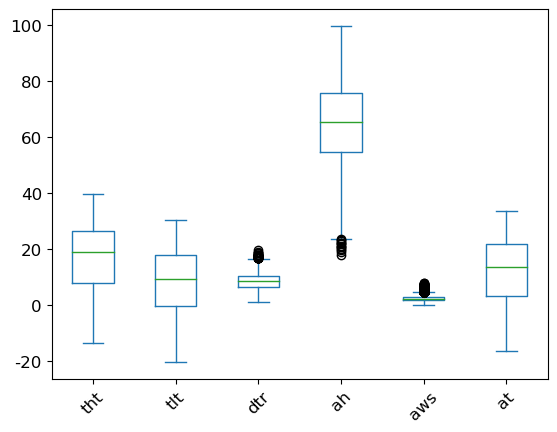

In [11]:
cleaned_df.loc[:, ['datetime','tht','tlt','dtr','ah','aws','at']].plot(kind='box',
                                                                        rot=45)
plt.show()

In [12]:
# cleaned_df.loc[:,'datetime'].plot(kind='box')
# plt.show() 

# 날짜 형식이라 표시할 데이터가 없음

findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font famil

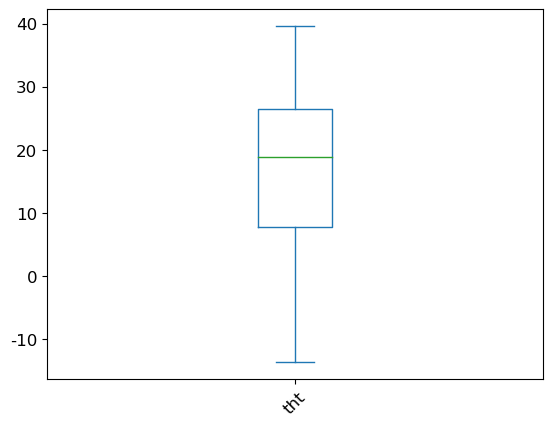

In [13]:
### tht(최고기온) 컬럼의 이상치의 존재 유무 개별 확인

cleaned_df.loc[:,'tht'].plot(kind='box', rot=45)
plt.show()

#이상치 없음

findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font famil

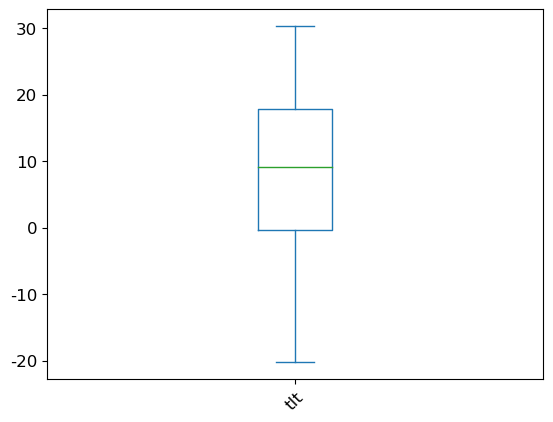

In [14]:
### tlt(최저기온) 컬럼의 이상치 존재 유무 확인
cleaned_df.loc[:, 'tlt'].plot(kind='box', rot=45)
plt.show()
# 이상치 없음

findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font famil

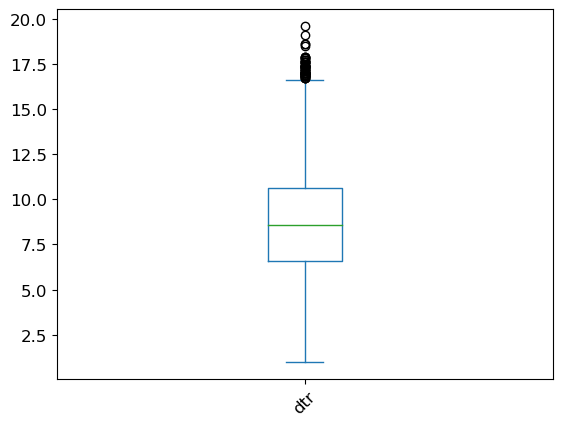

In [15]:
### dtr(일교차) 컬럼의 이상치 존재 유무 확인

cleaned_df.loc[:,'dtr'].plot(kind='box', rot=45)
plt.show() 

# 이상치 존재.

In [16]:
# dtr(일교차) 컬럼의 첫번째 이상치 제거.

'''
1. IQR = Q3- Q1
2. 정상 범위의 취소 : Q1 - (IQR*1.5)
3. 정상 범위의 최대 : Q3 + (IQR*1.5)
'''

Q1 = cleaned_df.loc[:,'dtr'].quantile(q=0.25)

Q3 = cleaned_df.loc[:,'dtr'].quantile(q=0.75)

IQR = Q3 -Q1

print(f'IQR의 값 : {IQR}')

print('*'*80)

print(f'제1사분위값 : {Q1}')

print('*'*80)

print(f'제3사분위값 : {Q3}')

print('*'*80)

MIN = Q1 - (IQR * 1.5 ) 

print(f'정상 범위의 최솟값 : {MIN}')
print('*'*80)

MAX = Q3 + (IQR * 1.5 )

print(f'정상 범위의 최댓값 : {MAX}')

print('*'*80)

condition1 = (cleaned_df.loc[:,'dtr']<MIN) | (cleaned_df.loc[:,'dtr']>MAX)

print('*'*80)

Outlier = cleaned_df.loc[condition1]
print(f' dtr 컬럼의 첫번째 이상치 : {Outlier}')

Outlier_index = cleaned_df.loc[condition1].index
print(f' dtr 컬럼의 첫번째 이상치 데이터의 인덱스 : {Outlier_index}')   

n_Outlier_index = len(Outlier_index)

print(f'첫번째 이상치의 인덱스 개수 : \n{n_Outlier_index}')

print('*'*80)

#-----------------------------------------------------

cleaned_dtr = cleaned_df.loc[:,'dtr'].drop(index=Outlier_index)
print(f' 첫번째 이상치를 제거한 결과 : \n{cleaned_dtr}')

# 여기서 인덱스넘버가 맞지 않는데 이건 다른 이상치가 있는 컬럼마저 전부 다 제거해놓고 pd.concat해서
# 합병까지 한 후에 나중에 reset_index하면 됨!

IQR의 값 : 4.0
********************************************************************************
제1사분위값 : 6.6
********************************************************************************
제3사분위값 : 10.6
********************************************************************************
정상 범위의 최솟값 : 0.5999999999999996
********************************************************************************
정상 범위의 최댓값 : 16.6
********************************************************************************
********************************************************************************
 dtr 컬럼의 첫번째 이상치 :          datetime   tht   tlt   dtr    ah  aws    at
99     1960-04-09  20.4   2.7  17.7  46.7  1.5  12.2
113    1960-04-23  25.3   8.0  17.3  54.3  1.7  15.9
120    1960-04-30  24.0   6.8  17.2  56.7  1.9  15.5
122    1960-05-02  26.0   6.4  19.6  45.0  1.6  17.1
462    1961-04-07  18.4   1.4  17.0  53.5  3.8   9.7
487    1961-05-02  21.2   4.2  17.0  60.0  2.3  13.4
821    1962-04-01  17.8   0.2  17.

findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font famil

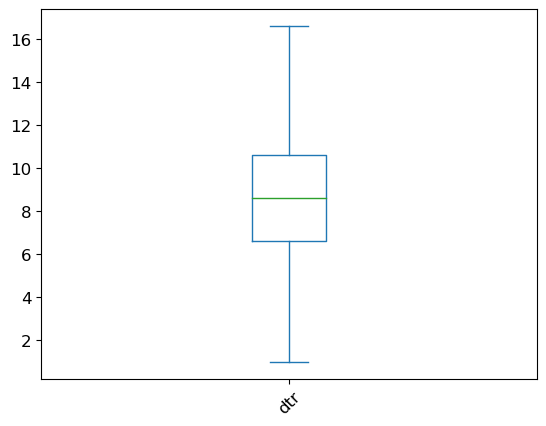

In [17]:
### dtr(일교차) 컬럼의 두번째 이상치 추출 및 제거

'''
1. IQR = Q3- Q1
2. 정상 범위의 취소 : Q1 - (IQR*1.5)
3. 정상 범위의 최대 : Q3 + (IQR*1.5)
'''

cleaned_dtr.plot(kind='box', rot=45)
plt.show()

# 이상치가 깔끔하게 제거됐음.

In [18]:
### ah(평균습도) 컬럼의 첫번째 이상치 추출 및 제거

'''
1. IQR = Q3- Q1
2. 정상 범위의 취소 : Q1 - (IQR*1.5)
3. 정상 범위의 최대 : Q3 + (IQR*1.5)
'''

Q1 = cleaned_df.loc[:,'ah'].quantile(q=0.25)

Q3 = cleaned_df.loc[:,'ah'].quantile(q=0.75)

IQR = Q3 -Q1

print(f'IQR의 값 : {IQR}')

print('*'*80)

print(f'제1사분위값 : {Q1}')

print('*'*80)

print(f'제3사분위값 : {Q3}')

print('*'*80)

MIN = Q1 - (IQR * 1.5 ) 

print(f'정상 범위의 최솟값 : {MIN}')
print('*'*80)

MAX = Q3 + (IQR * 1.5 )

print(f'정상 범위의 최댓값 : {MAX}')

print('*'*80)

condition1 = (cleaned_df.loc[:,'ah']<MIN) | (cleaned_df.loc[:,'ah']>MAX)

print('*'*80)

Outlier = cleaned_df.loc[condition1]
print(f' ah 컬럼의 첫번째 이상치 : {Outlier}')

Outlier_index = cleaned_df.loc[condition1].index
print(f' ah 컬럼의 첫번째 이상치 데이터의 인덱스 : {Outlier_index}')   

n_Outlier_index = len(Outlier_index)

print(f'첫번째 이상치의 인덱스 개수 : \n{n_Outlier_index}')

print('*'*80)

#-----------------------------------------------------

cleaned_ah = cleaned_df.loc[:,'ah'].drop(index=Outlier_index)
print(f' 첫번째 이상치를 제거한 결과 : \n{cleaned_ah}')

IQR의 값 : 20.9
********************************************************************************
제1사분위값 : 54.9
********************************************************************************
제3사분위값 : 75.8
********************************************************************************
정상 범위의 최솟값 : 23.55
********************************************************************************
정상 범위의 최댓값 : 107.14999999999999
********************************************************************************
********************************************************************************
 ah 컬럼의 첫번째 이상치 :          datetime   tht   tlt   dtr    ah  aws    at
13175  1996-01-30  -3.0  -9.1   6.1  20.8  4.3  -6.2
13191  1996-02-15   5.8  -4.0   9.8  20.8  4.5   1.2
13193  1996-02-17   3.2  -6.2   9.4  22.3  3.3  -2.0
13246  1996-04-10  12.2   4.2   8.0  19.0  4.3   7.6
16557  2005-05-04  27.7  12.6  15.1  21.1  1.8  20.1
17608  2008-03-20  17.9   5.2  12.7  19.9  2.7  11.6
17640  2008-04-21  23.5  17.1   

findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font famil

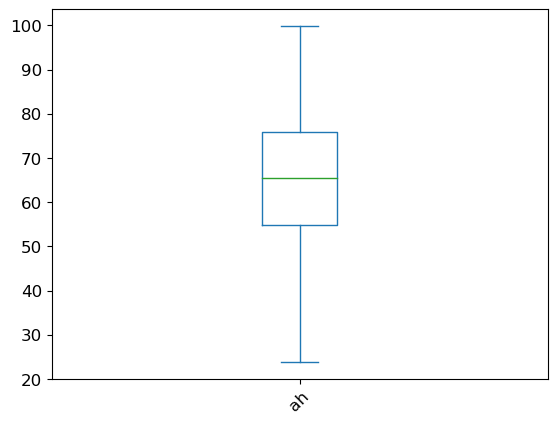

In [19]:
### 평균습도 컬럼의 두번째 이상치 추출 및 제거

'''
1. IQR = Q3- Q1
2. 정상 범위의 취소 : Q1 - (IQR*1.5)
3. 정상 범위의 최대 : Q3 + (IQR*1.5)
'''

cleaned_ah.plot(kind='box', rot=45)
plt.show()

# 이상치 제거 완료. 

In [20]:
### aws(평균풍속) 컬럼의 첫번째 이상치 추출 및 제거

'''
1. IQR = Q3- Q1
2. 정상 범위의 취소 : Q1 - (IQR*1.5)
3. 정상 범위의 최대 : Q3 + (IQR*1.5)
'''

Q1 = cleaned_df.loc[:,'aws'].quantile(q=0.25)

Q3 = cleaned_df.loc[:,'aws'].quantile(q=0.75)

IQR = Q3 -Q1

print(f'IQR의 값 : {IQR}')

print('*'*80)

print(f'제1사분위값 : {Q1}')

print('*'*80)

print(f'제3사분위값 : {Q3}')

print('*'*80)

MIN = Q1 - (IQR * 1.5 ) 

print(f'정상 범위의 최솟값 : {MIN}')
print('*'*80)

MAX = Q3 + (IQR * 1.5 )

print(f'정상 범위의 최댓값 : {MAX}')

print('*'*80)

condition1 = (cleaned_df.loc[:,'aws']<MIN) | (cleaned_df.loc[:,'aws']>MAX)

print('*'*80)

Outlier = cleaned_df.loc[condition1]
print(f' 평균풍속 컬럼의 첫번째 이상치 : {Outlier}')

Outlier_index = cleaned_df.loc[condition1].index
print(f' 평균풍속 컬럼의 첫번째 이상치 데이터의 인덱스 : {Outlier_index}')   

n_Outlier_index = len(Outlier_index)

print(f'첫번째 이상치의 인덱스 개수 : \n{n_Outlier_index}')

print('*'*80)

#-----------------------------------------------------

cleaned_aws1 = cleaned_df.loc[:,'aws'].drop(index=Outlier_index)
print(f' 첫번째 이상치를 제거한 결과 : \n{cleaned_aws1}')

IQR의 값 : 1.2
********************************************************************************
제1사분위값 : 1.7
********************************************************************************
제3사분위값 : 2.9
********************************************************************************
정상 범위의 최솟값 : -0.09999999999999987
********************************************************************************
정상 범위의 최댓값 : 4.699999999999999
********************************************************************************
********************************************************************************
 평균풍속 컬럼의 첫번째 이상치 :          datetime   tht   tlt   dtr    ah  aws    at
4      1960-01-05   1.3  -8.2   9.5  44.0  5.1  -4.6
71     1960-03-12   7.8  -4.1  11.9  54.7  5.8   1.5
87     1960-03-28  16.3   3.6  12.7  62.0  5.1  11.0
106    1960-04-16  12.7   4.7   8.0  52.3  6.2   8.3
177    1960-06-26  25.2  18.8   6.4  89.0  4.8  20.0
...           ...   ...   ...   ...   ...  ...   ...
21986  2020-03-19  

findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.


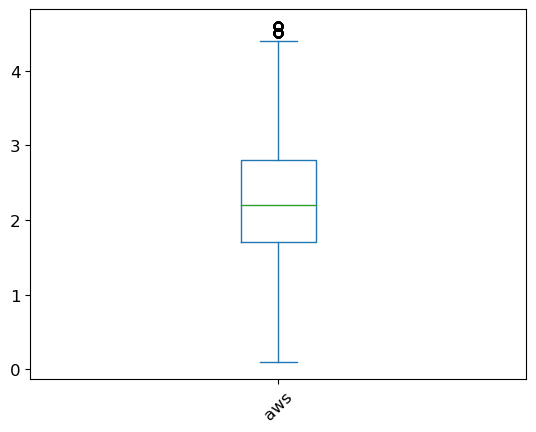

IQR의 값 : 1.0999999999999999
********************************************************************************
제1사분위값 : 1.7
********************************************************************************
제3사분위값 : 2.8
********************************************************************************
정상 범위의 최솟값 : 0.050000000000000044
********************************************************************************
정상 범위의 최댓값 : 4.449999999999999
********************************************************************************
********************************************************************************
 평균풍속 컬럼의 두번째 이상치 : 80       4.5
132      4.6
691      4.5
772      4.5
1149     4.6
        ... 
20495    4.6
21934    4.6
22113    4.6
22624    4.6
22894    4.6
Name: aws, Length: 204, dtype: float64
 평균풍속 컬럼의 두번째 이상치 데이터의 인덱스 : Index([   80,   132,   691,   772,  1149,  1185,  1407,  1424,  1447,  1881,
       ...
       19941, 20056, 20086, 20155, 20301, 20495, 21934, 22113, 22624, 22894]

In [21]:
### aws(평균풍속) 컬럼의 두번째 이상치 추출 및 제거

'''
1. IQR = Q3- Q1
2. 정상 범위의 취소 : Q1 - (IQR*1.5)
3. 정상 범위의 최대 : Q3 + (IQR*1.5)
'''

cleaned_aws1.plot(kind='box', rot=45)
plt.show()
# 아직도 이상치가 존재

Q1 = cleaned_aws1.quantile(q=0.25)

Q3 = cleaned_aws1.quantile(q=0.75)

IQR = Q3 -Q1

print(f'IQR의 값 : {IQR}')

print('*'*80)

print(f'제1사분위값 : {Q1}')

print('*'*80)

print(f'제3사분위값 : {Q3}')

print('*'*80)

MIN = Q1 - (IQR * 1.5 ) 

print(f'정상 범위의 최솟값 : {MIN}')
print('*'*80)

MAX = Q3 + (IQR * 1.5 )

print(f'정상 범위의 최댓값 : {MAX}')

print('*'*80)

condition2 = (cleaned_aws1<MIN) | (cleaned_aws1>MAX)

print('*'*80)

Outlier = cleaned_aws1[condition2]
print(f' 평균풍속 컬럼의 두번째 이상치 : {Outlier}')

Outlier_index = cleaned_aws1[condition2].index
print(f' 평균풍속 컬럼의 두번째 이상치 데이터의 인덱스 : {Outlier_index}')   

n_Outlier_index = len(Outlier_index)

print(f'첫번째 이상치의 인덱스 개수 : \n{n_Outlier_index}')

print('*'*80)

#-----------------------------------------------------

cleaned_aws2 = cleaned_aws1.drop(index=Outlier_index)
print(f' 첫번째 이상치를 제거한 결과 : \n{cleaned_aws2}')

findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.
findfont: Font family 'nanummyeongjo' not found.


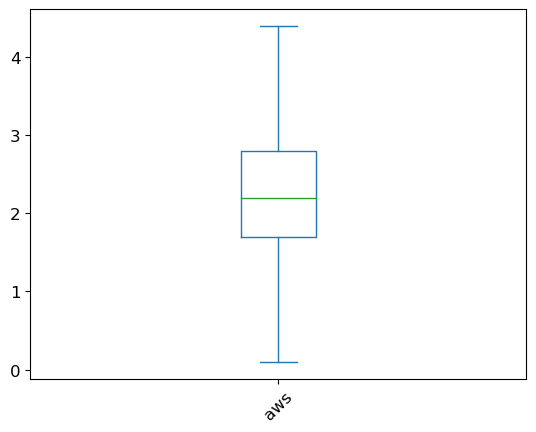

In [22]:
### aws(평균풍속) 컬럼의 세번째 이상치 추출 및 제거

'''
1. IQR = Q3- Q1
2. 정상 범위의 취소 : Q1 - (IQR*1.5)
3. 정상 범위의 최대 : Q3 + (IQR*1.5)
'''

cleaned_aws2.plot(kind='box', rot=45)
plt.show()
# 이상치 존재x

### 컬럼 병합

In [23]:
print(cleaned_df.columns)

print('*'*80)
print('*'*80)

data = [cleaned_df.loc[:,'datetime'],
        cleaned_df.loc[:,'tht'],
        cleaned_df.loc[:,'tlt'],
        cleaned_dtr,
        cleaned_ah,
        cleaned_aws2,
        cleaned_df.loc[:,'at']]
df_concat = pd.concat(data,
                      axis=1, 
                      join='inner')

print(df_concat)


# 인덱스 넘버안맞아서 reset_index로 재설정까지.

df_concat.reset_index(drop=True, inplace=True)
print(df_concat)

Index(['datetime', 'tht', 'tlt', 'dtr', 'ah', 'aws', 'at'], dtype='object')
********************************************************************************
********************************************************************************
         datetime   tht  tlt   dtr    ah  aws   at
0      1960-01-01   2.2 -5.2   7.4  68.3  1.7 -1.6
1      1960-01-02   1.2 -5.6   6.8  87.7  1.3 -1.9
2      1960-01-03   8.7 -2.1  10.8  81.3  3.0  4.0
3      1960-01-04  10.8  1.2   9.6  79.7  4.4  7.5
5      1960-01-06  -1.2 -9.5   8.3  51.3  1.8 -5.2
...           ...   ...  ...   ...   ...  ...  ...
22998  2022-12-27   3.3 -7.3  10.6  69.8  1.8 -2.6
22999  2022-12-28   0.1 -6.0   6.1  58.1  2.5 -3.3
23000  2022-12-29   2.1 -7.8   9.9  56.3  1.7 -2.9
23001  2022-12-30   2.3 -4.4   6.7  65.6  1.9 -1.8
23002  2022-12-31   2.1 -5.1   7.2  65.5  1.4 -1.2

[22105 rows x 7 columns]
         datetime   tht  tlt   dtr    ah  aws   at
0      1960-01-01   2.2 -5.2   7.4  68.3  1.7 -1.6
1      1960-01-02   1.

### datetime 처리

In [24]:
### df_train의 일시 컬럼을 datetime으로 변경
columns3 = cleaned_df.columns
print(columns3)

print('*'*80)

cleaned_df.columns = ['datetime', 'tht', 'tlt', 'dtr',
                      'ah', 'aws', 'at']

print(cleaned_df)

print('*'*80)

### 일시컬럼을 인덱스로 설정
cleaned_df.set_index('datetime', inplace=False)
print(f' 일시컬럼이 인덱스로 설정된 결과 : \n{cleaned_df}')


Index(['datetime', 'tht', 'tlt', 'dtr', 'ah', 'aws', 'at'], dtype='object')
********************************************************************************
         datetime   tht  tlt   dtr    ah  aws   at
0      1960-01-01   2.2 -5.2   7.4  68.3  1.7 -1.6
1      1960-01-02   1.2 -5.6   6.8  87.7  1.3 -1.9
2      1960-01-03   8.7 -2.1  10.8  81.3  3.0  4.0
3      1960-01-04  10.8  1.2   9.6  79.7  4.4  7.5
4      1960-01-05   1.3 -8.2   9.5  44.0  5.1 -4.6
...           ...   ...  ...   ...   ...  ...  ...
22998  2022-12-27   3.3 -7.3  10.6  69.8  1.8 -2.6
22999  2022-12-28   0.1 -6.0   6.1  58.1  2.5 -3.3
23000  2022-12-29   2.1 -7.8   9.9  56.3  1.7 -2.9
23001  2022-12-30   2.3 -4.4   6.7  65.6  1.9 -1.8
23002  2022-12-31   2.1 -5.1   7.2  65.5  1.4 -1.2

[23003 rows x 7 columns]
********************************************************************************
 일시컬럼이 인덱스로 설정된 결과 : 
         datetime   tht  tlt   dtr    ah  aws   at
0      1960-01-01   2.2 -5.2   7.4  68.3  1.7 -1.6


In [25]:
answer_col = cleaned_df.loc[:, 'at']

print(f'정답 컬럼 추출 : \n{answer_col}')

print('*'*80)

정답 컬럼 추출 : 
0       -1.6
1       -1.9
2        4.0
3        7.5
4       -4.6
        ... 
22998   -2.6
22999   -3.3
23000   -2.9
23001   -1.8
23002   -1.2
Name: at, Length: 23003, dtype: float64
********************************************************************************


In [26]:
print(cleaned_df.loc[:,'datetime'])

0        1960-01-01
1        1960-01-02
2        1960-01-03
3        1960-01-04
4        1960-01-05
            ...    
22998    2022-12-27
22999    2022-12-28
23000    2022-12-29
23001    2022-12-30
23002    2022-12-31
Name: datetime, Length: 23003, dtype: object


### datetime 컬럼 자료형 변환

In [27]:
### datetime컬럼을 to_datetime으로 자료형 변환

cleaned_df['datetime'] = pd.to_datetime(cleaned_df['datetime'])

cleaned_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23003 entries, 0 to 23002
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  23003 non-null  datetime64[ns]
 1   tht       23003 non-null  float64       
 2   tlt       23003 non-null  float64       
 3   dtr       23003 non-null  float64       
 4   ah        23003 non-null  float64       
 5   aws       23003 non-null  float64       
 6   at        23003 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 1.2 MB


In [28]:
print(cleaned_df.loc[:,'datetime'])

print('*'*80)

0       1960-01-01
1       1960-01-02
2       1960-01-03
3       1960-01-04
4       1960-01-05
           ...    
22998   2022-12-27
22999   2022-12-28
23000   2022-12-29
23001   2022-12-30
23002   2022-12-31
Name: datetime, Length: 23003, dtype: datetime64[ns]
********************************************************************************


### df_submission 제출용 파일의 컬럼을 영문으로 변환

In [29]:
print(df_submission.columns)

print('*'*80)

df_submission.columns = ['datetime','at']

print(df_submission)

df_submission.info()

df_submission['at'] = df_submission['at'].astype('float64')

df_submission.info()

Index(['일시', '평균기온'], dtype='object')
********************************************************************************
       datetime  at
0    2023-01-01   0
1    2023-01-02   0
2    2023-01-03   0
3    2023-01-04   0
4    2023-01-05   0
..          ...  ..
353  2023-12-20   0
354  2023-12-21   0
355  2023-12-22   0
356  2023-12-23   0
357  2023-12-24   0

[358 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  358 non-null    object
 1   at        358 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  358 non-null    object 
 1   at        358 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.7+ KB

### ARIMA 모델 학습

In [30]:
# index의 freq 속성을 'D'로 변경.
cleaned_df.index.freq = 'D'

# ARIMA Model Learning
model = ARIMA(cleaned_df['at'], order=(2, 1, 3))  # p, d, q 값은 조정 필요
model_fit = model.fit()

In [31]:
from statsmodels.tsa.arima.model import ARIMA

df_submission['datetime'] = pd.to_datetime(df_submission['datetime'])

df_submission['at'] = df_submission['at'].astype('float64')

# 예측할 기간 설정
start_date = cleaned_df.index.min()  # 학습용 데이터의 인덱스 최솟값 사용
end_date = cleaned_df.index.max()  # 학습용 데이터의 인덱스 최댓값 사용

# ARIMA 모델을 사용하여 예측
forecast = model_fit.predict(start=start_date, end=end_date, typ='levels')

#-------------------



### 예측 결과 저장

In [32]:
# 예측 결과 추출 및 확인
forecast_values = forecast.values

# 제출용 데이터프레임에 예측 결과 할당
df_submission['at'] = forecast_values[:len(df_submission)]

# 예측 결과 저장
df_submission.to_csv('df_train_submit.csv', index=False)